# Understanding Interpolation

This notebook works toward building an understanding of how the interpolation adjusts the scoring.

We'll be trying Linear and Quadratic for exact copies of a document added multiple times to the index.

### Setting up the Environment

You'll need to create an Azure Search Service before executing this script.  The accompanying powershell script will launch an Azure Search Service called osha and resolve to osha.search.windows.net.  It will also pull the admin secret key that we will use to create the index.  The powershell script will pull that key into a file called config.config.  

For production use, you should consider generating "**Query Keys**" which are read-only access to your Azure Search Service.

Lastly, we manually specify the API version here and it may change in later updates.  Find more here: https://docs.microsoft.com/en-us/azure/search/search-api-versions

In [1]:
URL = 'https://osha2.search.windows.net'
with open('./config.config', 'r') as f:
    KEY = f.read()
INDEX_NAME = 'interptest'

API = '2016-09-01'
headers = {'content-type': 'application/json', 'api-key': KEY}

index_url = ''.join([URL, '/indexes/',INDEX_NAME,'?api-version=',API])

In [2]:
import json
import requests
import os
import re
import datetime
import random
import pandas as pd
import matplotlib.pyplot as plt

The packages json and requests are the core of the REST API work.  The remaining packages are used for working with the demo data.

The following steps set up an index and the specific fields used in the index.

In [3]:
azure_index = dict()
azure_index["name"] = INDEX_NAME

In [4]:
azure_index["fields"] = [
       {"name": "sic4", "type": "Edm.String", "key":True, "searchable": True},
       {"name": "sic4title", "type": "Edm.String","filterable": False, "sortable": False, "facetable": False},
       {"name": "content", "type": "Edm.String", "filterable": False, "sortable": False, "facetable": False, 'retrievable':False},
       {"name": "oshaURL", "type": "Edm.String", "filterable": False, "sortable": False, "facetable": False},
       {"name": "sic2", "type": "Edm.String", "searchable": False},
       {"name": "updateDate", "type": "Edm.DateTimeOffset", "searchable": False,"facetable":False},
      ]

### Scoring Profiles

A scoring profile allows you to augment the relevancy score of each document.  In the case below, I am boosting any page that was updated in the last 60 days by a huge amount (boost: 1000).  The "interpolation" attribute controls the effect over a range of values.  In this case, I'm using **linear** so a one day difference is the same across the past 60 days.  Other options like Quadratic and Log10 would have greater differences between documents in the middle than documents at the end.

More here: https://docs.microsoft.com/en-us/rest/api/searchservice/add-scoring-profiles-to-a-search-index

In [5]:
azure_index["scoringProfiles"] = []

This first score profile will be a **linear** boost based on the past 15 days.

In [6]:
scoreProfile = dict()

scoreProfile["name"] = "newerPagesLIN"
scoreProfile["functions"] = []

score_func = {"type": "freshness", "fieldName": "updateDate", "boost": 10,\
              "interpolation": "linear",\
              "freshness": {"boostingDuration": "P15D"}
             }

scoreProfile["functions"].append(score_func)

This second score profile will be a **QUADRATIC** boost based on the past 15 days.

In [7]:
scoreProfile2 = dict()

scoreProfile2["name"] = "newerPagesQUAD"
scoreProfile2["functions"] = []

score_func2 = {"type": "freshness", "fieldName": "updateDate", "boost": 10,\
              "interpolation": "quadratic",\
              "freshness": {"boostingDuration": "P15D"}
             }

scoreProfile2["functions"].append(score_func2)

In [8]:
azure_index["scoringProfiles"].append(scoreProfile)
azure_index["scoringProfiles"].append(scoreProfile2)

## Drop the Index (In Case it Exists)

A status code of 204 is a successful drop of the index with no content being returned.

In [9]:
drop = requests.delete(index_url, headers=headers)

In [10]:
print(drop.status_code)
print(drop.content)

204
b''


## Put the Index

In order to create the initial index, we PUT the azure_index dictionary as a json file to the index_url.

A status code of 201 means a successful creation of the index.

In [11]:
json_index = json.dumps(azure_index, ensure_ascii=False,indent=2)

In [12]:
put_index = requests.put(index_url, headers=headers, data = json_index)

In [13]:
print(put_index.status_code)
print(put_index.content)

201
b'{"@odata.context":"https://osha2.search.windows.net/$metadata#indexes/$entity","@odata.etag":"\\"0x8D5636C687D7CB9\\"","name":"interptest","fields":[{"name":"sic4","type":"Edm.String","searchable":true,"filterable":true,"retrievable":true,"sortable":true,"facetable":true,"key":true,"indexAnalyzer":null,"searchAnalyzer":null,"analyzer":null},{"name":"sic4title","type":"Edm.String","searchable":true,"filterable":false,"retrievable":true,"sortable":false,"facetable":false,"key":false,"indexAnalyzer":null,"searchAnalyzer":null,"analyzer":null},{"name":"content","type":"Edm.String","searchable":true,"filterable":false,"retrievable":false,"sortable":false,"facetable":false,"key":false,"indexAnalyzer":null,"searchAnalyzer":null,"analyzer":null},{"name":"oshaURL","type":"Edm.String","searchable":true,"filterable":false,"retrievable":true,"sortable":false,"facetable":false,"key":false,"indexAnalyzer":null,"searchAnalyzer":null,"analyzer":null},{"name":"sic2","type":"Edm.String","searchabl

## Adding Content to the Index

The next step is to get the documents into the index.

We must POST the data as a json object to the index_url.  Each field must be represented and a "@search.action" must be set as "upload" on every entry.

In this example, the data is stored in the /data folder.  For every page, we'll need to create an entry and fill in the values for each element of the index.

For exploring the interpolation effect, we'll load **20 copies of the exact same file** up to Azure Search but the date timestamp associated with each file will be different.

In [14]:
content_url = ''.join([URL, '/indexes/',INDEX_NAME,'/docs/index?api-version=',API])

In [15]:
files = os.listdir('.\\data')
files_filtered = [file for file in files if re.match('Description_for_2053',file)]

In [16]:
duplicate_files = [files_filtered[0] for x in range(0,20)]

Now that we have duplicate documents each one will be considered "updated" a certain number of days ago.  Using today's date, a number of days will be subtracted and we should have a linear pattern we can follow in the search results.

In [17]:
today = datetime.datetime.now()

In [18]:
value = []

for dayOffset, file in enumerate(duplicate_files):
    sic4 = file[16:20]
    sic2 = file[16:18]
    with open(os.path.join(os.getcwd(),'data',file), 'r') as f:
        content = ''.join(f.readlines())
    
    h2_pattern = re.compile(r'<h2>(.*)</h2>')
    
    content_nonewlines = content.replace('\n','')
    
    sic4title = re.findall(h2_pattern, content_nonewlines)[0].strip()
    
    updateDate = today - datetime.timedelta(days = dayOffset)
    
    file_dict = {
        "@search.action": "upload",
        "sic4": sic4+str(dayOffset),
        "sic4title": sic4title,
        "content": content,
        "oshaURL": "https://www.osha.gov/pls/imis/sic_manual.html",
        "sic2": sic2,
        # Dates are DateTimeOffset based on the OData V4 standard
        "updateDate":updateDate.strftime('%Y-%m-%dT%H:%M:%SZ')
    }
    value.append(file_dict)

In [19]:
print(value[0]["updateDate"])
print(value[1]["updateDate"])
print(value[2]["updateDate"])

2018-01-24T14:52:40Z
2018-01-23T14:52:40Z
2018-01-22T14:52:40Z


### Loading the data to the index with POST

You are limited to 1,000 or fewer documents in a single request.  In case you use this for more than 1,000 documents, this for loop should help throttle how much you add each time.

In [20]:
units_of_1k = int(round(len(value)/1000,0))
remainder = len(value) % 1000

if len(value) < 1000:
    units_of_1k = 1
elif remainder != 0:
    units_of_1k+=1

for x in range(units_of_1k):
    start = x*1000
    end = x*1000+1000
    print(str(start)+'-'+str(end))
    
    json_value = json.dumps({'value':value[start:end]}, ensure_ascii=False,indent=2)
    post_value = requests.post(content_url, headers=headers, data = json_value)
    
    print('Status Code:'+str(post_value.status_code))

0-1000
Status Code:200


## Query the Index

We'll query the index three times.  1.) Without any scoring profile, 2.) with the Linear scoring profile, and 3.) with the Quadratic scoring profile.

In [21]:
QUERY = 'bakery'

The following functions help to simplify the query processing parts in the cells further below.

Mainly creating a wrapper to take the request, bring only the columns we're interested in and then create a DataFrame for further exploration / display.

In [22]:
def query_index(params, headers, index, api):
    """Standard way of searching a particular index.
    """
    search_url = ''.join([URL, '/indexes/',index,'/docs?api-version=',api])
    results = requests.get(search_url, params=params,headers=headers)
    return results    

In [23]:
def unpack_id_scores(results):
    """Takes query results and returns a dictionary ready to be ingested as a dataframe
    """
    list_of_dicts = []
    for element in results:
        docid = int(element['sic4'][4:])
        score = element['@search.score']
        upd = element['updateDate']
        list_of_dicts.append({'doc':docid,'score':score,'updateDate':upd})
    return list_of_dicts

In [24]:
def query_to_df(results):
    """Returns a DataFrame (sorted on doc column).  
    Requires the ['value'] section of a Azure Search json result.
    """
    list_of_dicts = unpack_id_scores(results)
    return pd.DataFrame(list_of_dicts).sort_values(by=["doc"])

## Use Search Profile on the Index to Boost Pages

Now we use the newerPagesLIN and newerPagesQUAD scoring profiles to enhance the scores.  You can see that the pages are returned in the same order but with slightly different score.

More on the Scoring Profiles and Interpolation https://docs.microsoft.com/en-us/rest/api/searchservice/add-scoring-profiles-to-a-search-index#bkmk_interpolation

In [25]:
no_profile = query_index({'search':QUERY}, headers, INDEX_NAME, API)
norm_df = query_to_df(no_profile.json()['value'])
norm_df.head()

,doc,score,updateDate
12,0,0.064849,2018-01-24T14:52:40Z
0,1,0.064849,2018-01-23T14:52:40Z
2,2,0.064849,2018-01-22T14:52:40Z
4,3,0.064849,2018-01-21T14:52:40Z
6,4,0.064849,2018-01-20T14:52:40Z


In [26]:
lin_profile = query_index(
    {'search':QUERY,'scoringProfile':'newerPagesLIN'},
    headers, INDEX_NAME, API)
lin_df = query_to_df(lin_profile.json()['value'])
lin_df.head()

,doc,score,updateDate
0,0,0.638763,2018-01-24T14:52:40Z
1,1,0.599854,2018-01-23T14:52:40Z
2,2,0.560944,2018-01-22T14:52:40Z
3,3,0.522035,2018-01-21T14:52:40Z
4,4,0.483125,2018-01-20T14:52:40Z


In [27]:
quad_profile = query_index(
    {'search':QUERY,'scoringProfile':'newerPagesQUAD'},
    headers, INDEX_NAME, API)
quad_df = query_to_df(quad_profile.json()['value'])
quad_df.head()

,doc,score,updateDate
0,0,0.629198,2018-01-24T14:52:40Z
1,1,0.555270,2018-01-23T14:52:40Z
2,2,0.486530,2018-01-22T14:52:40Z
3,3,0.422978,2018-01-21T14:52:40Z
4,4,0.364614,2018-01-20T14:52:40Z


Now let's get the full data and see that linear and quadratic trend.

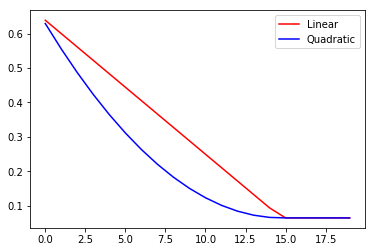

In [28]:
plt.plot(lin_df['doc'],lin_df['score'],color="red",label="Linear")
plt.plot(quad_df['doc'],quad_df['score'],color="blue",label="Quadratic")
plt.legend(loc='best')
plt.show()

In [29]:
merged_df = lin_df.merge(right=quad_df, how="inner", on=["doc"]).\
merge(right=norm_df, how="inner", on='doc')

final_df = merged_df[merged_df.columns.drop(['updateDate_x','updateDate_y','updateDate'])]

final_df = final_df.rename(columns={'score_x': 'linBoost', 'score_y': 'quadBoost', 'score':'normal'})

In [30]:
final_df.head(35)

,doc,linBoost,quadBoost,normal
0,0,0.638763,0.629198,0.064849
1,1,0.599854,0.555270,0.064849
2,2,0.560944,0.486530,0.064849
3,3,0.522035,0.422978,0.064849
4,4,0.483125,0.364614,0.064849
5,7,0.366397,0.220649,0.064849
6,8,0.327488,0.183036,0.064849
7,11,0.210759,0.101327,0.064849
8,12,0.171850,0.084466,0.064849
9,15,0.064849,0.064849,0.064849


So what does this all mean?  For a quadratic interpolation, a *recent* one day difference carries a harher penalty than an *older* one day difference.  This makes sense when you want to really push new content and there's a slow decrease in the benefit of being new until you reach the end of the boosting period (in our case, 15 days) and then the benefit disappears completely.

In [31]:
diffs = final_df.set_index('doc').diff()
diffs

,linBoost,quadBoost,normal
doc,,,
0,NaN,NaN,NaN
1,-0.038909,-0.073928,0.0
2,-0.038909,-0.068740,0.0
3,-0.038909,-0.063552,0.0
4,-0.038909,-0.058364,0.0
7,-0.116728,-0.143965,0.0
8,-0.038909,-0.037612,0.0
11,-0.116728,-0.081710,0.0
12,-0.038909,-0.016861,0.0


### What does this all mean?

This shows the Quadratic and Linear interpolations on a regular interval.  You can use these different interpolations to help boost content using your scoring profile.  If going from six days old to seven days old feels the same as going from 14 to 15 days old, stick with Linear.  

If you believe that there's little benefit in boosting 14 days old more than 15 days old but there's a big difference in boosting one day from two days then Quadratic is a better route for you.